The goal of this notebook is to prepare reference and visum data and save them as h5ad files
Do not forget to check:
1. check presence of all necessary covariates in adata.obs
2. check number of cell per each type; cell types with less than 20 (50?) cells should be used with caution (it is better to remove them)
3. remove MT genes
4. adata.X stores raw (at least integer) read counts. Try denormalization with CalculateRaw otherwise
5. ensure that both vis and ref use same gene naming (names or ens ids)


In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import anndata
from collections import Counter
import glob
import math

# Reference
## load data

In [2]:
lustre_path='/lustre/scratch117/cellgen/cellgeni/TIC-misc/tic-1632'

In [4]:
ref = sc.read_h5ad('/nfs/team205/ly5/adult_endo/visium/gut/visium_ref_gut_12organs_20220618.h5ad')
ref.shape

(225206, 30507)

## Check genes

In [5]:
ref.var

,gene_ids-0,feature_types-0,ENSG-0-0-0-1,gene_names_hg_v3.0-0-0-0-1,gene_names_hg_v1.2-0-0-0-1,gene_names_kidney-0-0-0-1
MIR1302-2HG,ENSG00000243485,Gene Expression,ENSG00000243485,MIR1302-2HG,RP11-34P13.3,MIR1302-10
FAM138A,ENSG00000237613,Gene Expression,ENSG00000237613,FAM138A,FAM138A,FAM138A
AL627309.1,ENSG00000238009,Gene Expression,ENSG00000238009,AL627309.1,RP11-34P13.7,RP11-34P13.7
AL627309.3,ENSG00000239945,Gene Expression,ENSG00000239945,AL627309.3,RP11-34P13.8,RP11-34P13.8
AL627309.2,ENSG00000239906,Gene Expression,ENSG00000239906,AL627309.2,RP11-34P13.14,RP11-34P13.14
...,...,...,...,...,...,...
AC004556.1,ENSG00000276345,Gene Expression,ENSG00000276345,AC004556.1,AC004556.1,nan
AC233755.2,ENSG00000277856,Gene Expression,ENSG00000277856,AC233755.2,AC233755.2,nan
AC233755.1,ENSG00000275063,Gene Expression,ENSG00000275063,AC233755.1,AC233755.1,nan
AC240274.1,ENSG00000271254,Gene Expression,ENSG00000271254,AC240274.1,AC240274.1,nan


In [12]:
a = [not str(gene).startswith('MT-') for gene in ref.var['gene_names_hg_v3.0-0-0-0-1']]
Counter(a)

Counter({True: 30507})

In [13]:
ref = ref[:,a]
ref.shape

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(225206, 30507)

## Check counts

In [8]:
# from https://github.com/brianpenghe/python-genomics/blob/master/Scanpyplus.py
def CalculateRaw(adata,scaling_factor=10000):
    #update by Polanski in Feb 2022
    #The object must contain a log-transformed matrix
    #This function returns an integer-count object
    #The normalization constant is assumed to be 10000
    #return anndata.AnnData(X=sparse.csr_matrix(np.rint(np.array(np.expm1(adata.X).todense().transpose())*(adata.obs['n_counts'].values).transpose() / scaling_factor).transpose()),\
    #              obs=adata.obs,var=adata.var,obsm=adata.obsm,varm=adata.varm)
    X = np.expm1(adata.X)
    scaling_vector = adata.obs['n_counts'].values / scaling_factor
    #.indptr[i]:.indptr[i+1] provides the .data coordinates where the i'th row of the data resides in CSR
    #which happens to be a cell, which happens to be what we have a unique entry in scaling_vector for
    for i in np.arange(X.shape[0]):
        X.data[X.indptr[i]:X.indptr[i+1]] = X.data[X.indptr[i]:X.indptr[i+1]] * scaling_vector[i]
    return anndata.AnnData(X=np.rint(X),obs=adata.obs,var=adata.var,obsm=adata.obsm,varm=adata.varm)

In [14]:
ref.X.data

array([1.005e+03, 6.000e+00, 2.740e+02, ..., 1.000e+00, 1.000e+00,
       3.000e+00], dtype=float32)

(array([2.14603939e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.77986920e+07, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.80578200e+07, 0.00000000e+00,
        0.00000000e+00, 9.15067500e+06, 0.00000000e+00, 5.49321000e+06,
        0.00000000e+00, 3.66168600e+06, 0.00000000e+00, 2.62629800e+06,
        1.97765900e+06, 1.54544500e+06, 1.24523700e+06, 1.02521000e+06,
        8.58892000e+05, 1.36249900e+06, 5.48560000e+05, 9.07928000e+05,
        7.20789000e+05, 5.86591000e+05, 4.86532000e+05, 5.88268000e+05,
        4.65373000e+05, 3.77325000e+05, 3.10252000e+05, 3.35619000e+05,
        2.69273000e+05, 2.68482000e+05, 2.13980000e+05, 2.04654000e+05,
        1.63445000e+05, 1.51223000e+05, 1.36590000e+05, 1.21352000e+05,
        9.60760000e+04, 9.37910000e+04, 8.08940000e+04, 6.94750000e+04,
        6.06260000e+04, 5.52100000e+04, 4.91670000e+04, 4.33890000e+04,
        3.77670000e+04, 3.26780000e+04, 2.80190000e+04, 2.587900

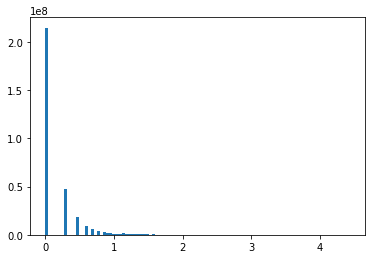

In [23]:
plt.hist(np.log10(ref.X.data),100)

In [ ]:
# de norm
# Ling told data are raw, so no de-norm is required
# ref = CalculateRaw(ref)
# ref.X.data

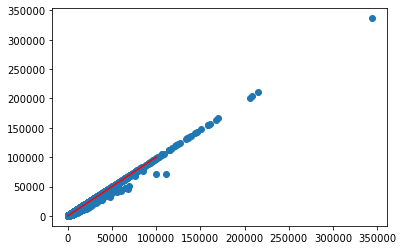

In [10]:
plt.scatter(ref.obs['total_counts'].values - ref.obs['total_counts_mt'].values,ref.X.sum(1).tolist())
plt.plot([0, 1e5], [0, 1e5],color='red')
# n_counts seems to hold sums of log-normalazed data

In [11]:
ref.shape

(516891, 29764)

## Check obs

In [24]:
ref.obs_keys()

['donor',
 'Diagnosis',
 'age',
 'batch',
 'location',
 'sorting',
 'gender',
 'Region',
 'kit',
 'id',
 'n_genes',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_mt',
 'pct_counts_mt',
 'doublet_scores',
 'predicted_doublets',
 'gut_celltype_broad',
 'Age_group',
 'gut_celltype_fine',
 'ann_visium_ref',
 'organ',
 'dissociation',
 'scrublet_score',
 'doublet_pval',
 'doublet_bh_pval',
 'percent_mito',
 'percent_ribo',
 'sample',
 'published_annotation',
 'HCA',
 'published_annotation_skin',
 'ann_organ_kidney',
 'ann_organ_liver',
 'ann_organ_skin',
 'ann_organ_skin_',
 'leiden_scVI_mural',
 'stress_genes_count',
 'ann_organ_lung',
 'ann_organ_heart',
 'ann_organ_muscle',
 'ann_organ_uterus',
 'ann_organ_female',
 'published_annotation_heart',
 'stress_genes_expression',
 'ann_vas_organ',
 'publication',
 'ann_vas_broad',
 'n_counts',
 'ann_organ_gut',
 'ann_organ_imm',
 'ann_organ_oeso',
 'ann_vas_1',
 'ann_vas_2',
 'ann_vas_3',
 'cell_or_nuclei',
 'test',
 'type_organ']

In [25]:
ref.obs

,donor,Diagnosis,age,batch,location,sorting,gender,Region,kit,id,...,n_counts,ann_organ_gut,ann_organ_imm,ann_organ_oeso,ann_vas_1,ann_vas_2,ann_vas_3,cell_or_nuclei,test,type_organ
AAACGGGCAGTCAGAG-1-Human_colon_16S8000511-0,A32 (411C),Healthy adult,25-30,0,SCL,SC-45N,M,LargeInt,10x5prime,Human_colon_16S8000511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAGCAATCCGTTGTC-1-Human_colon_16S8000511-0,A32 (411C),Healthy adult,25-30,0,SCL,SC-45N,M,LargeInt,10x5prime,Human_colon_16S8000511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAGTAGGTAGCAAAT-1-Human_colon_16S8000511-0,A32 (411C),Healthy adult,25-30,0,SCL,SC-45N,M,LargeInt,10x5prime,Human_colon_16S8000511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAATGCCTCGACAGCC-1-Human_colon_16S8000511-0,A32 (411C),Healthy adult,25-30,0,SCL,SC-45N,M,LargeInt,10x5prime,Human_colon_16S8000511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACACGTAGAGCCCAA-1-Human_colon_16S8000511-0,A32 (411C),Healthy adult,25-30,0,SCL,SC-45N,M,LargeInt,10x5prime,Human_colon_16S8000511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTGAAGTTCTACTCAT-FCA7511884-0-11-1,F40,NaN,7,1,placenta,SC-ALL,female,NaN,10x3prime_v2,FCA7511884,...,2944.019043,NaN,NaN,NaN,lymphatic_ec,13_lymphatic_ec,13,cells,12,13_lymphatic_ec_placenta
ACTGAGTTCGGAGGTA-FCA7511884-0-11-1,F40,NaN,7,1,placenta,SC-ALL,female,NaN,10x3prime_v2,FCA7511884,...,2653.596680,NaN,NaN,NaN,lymphatic_ec,13_lymphatic_ec,13,cells,12,13_lymphatic_ec_placenta
CATGACACAGTATCTG-FCA7511884-0-11-1,F40,NaN,7,1,placenta,SC-ALL,female,NaN,10x3prime_v2,FCA7511884,...,2955.036865,NaN,NaN,NaN,lymphatic_ec,13_lymphatic_ec,13,cells,12,13_lymphatic_ec_placenta
GGAATAAGTCGCATCG-FCA7511884-0-11-1,F40,NaN,7,1,placenta,SC-ALL,female,NaN,10x3prime_v2,FCA7511884,...,2955.825439,NaN,NaN,NaN,lymphatic_ec,13_lymphatic_ec,13,cells,12,13_lymphatic_ec_placenta


In [26]:
ref.obs['id'].value_counts()

WTDAtest7844018           9485
WTDAtest7844016           8596
Human_colon_16S8000513    6844
Human_colon_16S8001903    6800
WTDAtest7844015           5785
                          ... 
HCATisStab7413619            4
Human_colon_16S8002573       3
FCA7196220                   2
HCATisStab7619066            1
WSSS_A_LNG8620068            1
Name: id, Length: 277, dtype: int64

In [27]:
ref.obs['donor'].value_counts()

A33 (414C)           37472
A34 (417C)           27502
A32 (411C)           21940
A39 (440C)           14430
A34                  12441
                     ...  
kpmp-Trans-SV-004       27
kpmp-Trans-SV-007       15
kpmp-HK_PH              13
kpmp-18-162             12
F37                      7
Name: donor, Length: 74, dtype: int64

In [28]:
ref.obs['cell_or_nuclei'].value_counts()

cells    100839
Name: cell_or_nuclei, dtype: int64

In [29]:
cc = ref.obs['ann_visium_ref'].value_counts()
cc

TA                    43497
4_capillary_ec        18427
14_arterial_smc       15552
IgA plasma cell       14549
20_pericytes          12957
                      ...  
K cells (GIP+)            3
LEC2 (MADCAM1+)           3
CLC+ Mast cell            3
Fetal arterial EC         2
Stromal 2 (CH25H+)        2
Name: ann_visium_ref, Length: 94, dtype: int64

In [30]:
# remove celltypes with small number of cells (if necessary)
ctf = ref.obs['ann_visium_ref'].isin(cc.index[cc>=20].tolist())

In [31]:
Counter(ctf)

Counter({True: 225117, False: 89})

In [ ]:
#sc.write(adata=ref,filename=lustre_path+'/ref.h5ad')

In [32]:
ref = ref[ctf,:]
ref.shape

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(225117, 30507)

In [33]:
sc.write(adata=ref,filename=lustre_path+'/ref.filtered.h5ad')

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_doublets' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'ann_organ_liver' as categorical


# Visium

In [9]:
path2spacerangers = '/nfs/team205/vk7/sanger_projects/large_data/gut_kj_re/oxford_visium'
sids = ['A1','A2']
sids

['A1', 'A2']

In [10]:
#vs = [sc.read_h5ad(path2spacerangers+'/'+f+'.h5ad') for f in sids]
#vs = [sc.read_visium(path2spacerangers+'/'+f+"/outs/") for f in sids]
vs = [sc.read_visium(path2spacerangers+'/'+f,count_file='raw_feature_bc_matrix.h5') for f in sids]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
sids2=['WSSS_A_GUTsp9518706','WSSS_A_GUTsp9518708']
vs2 = [sc.read_visium(lustre_path+"/rawdata/"+f,count_file='raw_feature_bc_matrix.h5') for f in sids2]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [12]:
vs = vs + vs2
sids=sids+sids2

In [13]:
for i in range(len(vs)):
    vs[i].obs['barcode'] = vs[i].obs_names
    vs[i].obs_names = sids[i] + '_'+ vs[i].obs_names
    vs[i].obs['library_id']=sids[i]
    vs[i].var_names_make_unique()
    #vs[i].var['SYMBOL'] = vs[i].var_names
    #vs[i].var.set_index('gene_ids', drop=True, inplace=True)
    
    # to fix library id in uns
    old_key = list(vs[i].uns['spatial'].keys())[0]
    vs[i].uns['spatial'][sids[i]] = vs[i].uns['spatial'][old_key]
    del vs[i].uns['spatial'][old_key]


[x.shape[0] for x in vs]

[4992, 4992, 4992, 4992]

In [14]:
vis = vs[0].concatenate(vs[1:],uns_merge='unique')
vis

AnnData object with n_obs × n_vars = 19968 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'barcode', 'library_id', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [15]:
vis.obs

,in_tissue,array_row,array_col,barcode,library_id,batch
A1_AAACAACGAATAGTTC-1-0,0,0,16,AAACAACGAATAGTTC-1,A1,0
A1_AAACAAGTATCTCCCA-1-0,1,50,102,AAACAAGTATCTCCCA-1,A1,0
A1_AAACAATCTACTAGCA-1-0,0,3,43,AAACAATCTACTAGCA-1,A1,0
A1_AAACACCAATAACTGC-1-0,0,59,19,AAACACCAATAACTGC-1,A1,0
A1_AAACAGAGCGACTCCT-1-0,1,14,94,AAACAGAGCGACTCCT-1,A1,0
...,...,...,...,...,...,...
WSSS_A_GUTsp9518708_TTGTTTCACATCCAGG-1-3,0,58,42,TTGTTTCACATCCAGG-1,WSSS_A_GUTsp9518708,3
WSSS_A_GUTsp9518708_TTGTTTCATTAGTCTA-1-3,0,60,30,TTGTTTCATTAGTCTA-1,WSSS_A_GUTsp9518708,3
WSSS_A_GUTsp9518708_TTGTTTCCATACAACT-1-3,0,45,27,TTGTTTCCATACAACT-1,WSSS_A_GUTsp9518708,3
WSSS_A_GUTsp9518708_TTGTTTGTATTACACG-1-3,0,73,41,TTGTTTGTATTACACG-1,WSSS_A_GUTsp9518708,3


In [16]:
vis.obs_names = vis.obs['barcode'] + '_' + vis.obs['library_id']
vis.obs = vis.obs.drop(columns='batch',errors='ignore')
vis.obs

,in_tissue,array_row,array_col,barcode,library_id
AAACAACGAATAGTTC-1_A1,0,0,16,AAACAACGAATAGTTC-1,A1
AAACAAGTATCTCCCA-1_A1,1,50,102,AAACAAGTATCTCCCA-1,A1
AAACAATCTACTAGCA-1_A1,0,3,43,AAACAATCTACTAGCA-1,A1
AAACACCAATAACTGC-1_A1,0,59,19,AAACACCAATAACTGC-1,A1
AAACAGAGCGACTCCT-1_A1,1,14,94,AAACAGAGCGACTCCT-1,A1
...,...,...,...,...,...
TTGTTTCACATCCAGG-1_WSSS_A_GUTsp9518708,0,58,42,TTGTTTCACATCCAGG-1,WSSS_A_GUTsp9518708
TTGTTTCATTAGTCTA-1_WSSS_A_GUTsp9518708,0,60,30,TTGTTTCATTAGTCTA-1,WSSS_A_GUTsp9518708
TTGTTTCCATACAACT-1_WSSS_A_GUTsp9518708,0,45,27,TTGTTTCCATACAACT-1,WSSS_A_GUTsp9518708
TTGTTTGTATTACACG-1_WSSS_A_GUTsp9518708,0,73,41,TTGTTTGTATTACACG-1,WSSS_A_GUTsp9518708


In [17]:
vis.var

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38
AC233755.1,ENSG00000275063,Gene Expression,GRCh38
AC240274.1,ENSG00000271254,Gene Expression,GRCh38
AC213203.1,ENSG00000277475,Gene Expression,GRCh38


In [18]:
vis.write(lustre_path+"/viss.h5ad")

... storing 'barcode' as categorical
... storing 'library_id' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
